# Gudhi Examples
This Jupyter Notebook explores the Gudhi python library for the use of Topological Data analysis

To install Gudhi follow the instrustions here: [Installing Gudhi](https://gudhi.inria.fr/python/latest/installation.html)

Detailed documentation of the Gudhi Library can be found here: [documentation](https://gudhi.inria.fr/python/latest/).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import time
import gudhi

# ipython to display plots. You may need to run 'pip install ipython'
# Using this mode will make 3d plots interactable meaning you can rotate the plots
# How ever this will also open plots in a new window.
# Uncomment this line to use the ipython backend
# %matplotlib

# Disable latex compilation for plots. See installing gudhi above for require latex packages if you want to use latex
gudhi.persistence_graphical_tools._gudhi_matplotlib_use_tex=False

The following two functions have been included to easily create and visualize point clouds from spheres of any dimension

In [3]:
def generate_point_cloud_from_sphere(num_points=100, radius=1, dim=2, error=.2):
    """
    Generates a point cloud from a sphere with dimension dim

    :param num_points: Number of points in generated point cloud
    :param radius: radius of sphere that points are picked from
    :param dim: dimension of the space in which the sphere will be created. dim=2 a circle, dim=3 a sphere and so on
    :param error: this specifies uncertainly in the points. Possible Error is selected uniformly between the interval [-error, error], for each coordinate in each point
    :return: numpy array of the points in the point cloud
    """
    def apply_error(val):
        """ Helper function to add the error """
        return val + random.uniform(-1 * error, error)

    # First generate random array of size (dim, num_points) and normalize them so they fall on unit ball
    random_points = np.random.normal(size=(dim, num_points))
    random_points /= np.linalg.norm(random_points, axis=0)

    # Return the list of random points scaled by the radius and with a random error applied
    return radius * np.array([[apply_error(p) for p in row] for row in random_points]).T


def draw_point_cloud(data, e_radius=None, save_file=None):
    """
    Draws point cloud in either 2 or 3 dimensional space

    :param data: Point cloud as numpy array
    :param e_radius: Radius of epsilon balls. Use None to not include them
    :param save_file: Save file location (without .png) to save plot, Also acts as title
    :return: figure, wont open window of figure, so you must do plt.show()
    """
    fig = plt.figure()

    if data.shape[1] == 2:
        x = data.T[0]
        y = data.T[1]

        ax = fig.add_subplot()

        ax.scatter(x, y)

        if e_radius is not None:
            theta = np.linspace(0, 2 * np.pi, 150)
            for xp, yp in zip(x, y):
                ax.plot(e_radius * np.cos(theta) + xp, e_radius * np.sin(theta) + yp, color='black')
        ax.set_aspect('equal', adjustable='box')
    elif data.shape[1] == 3:
        x = data.T[0]
        y = data.T[1]
        z = data.T[2]

        ax = fig.add_subplot(projection='3d')

        ax.scatter(x, y, z)

        if e_radius is not None:
            phi, theta = np.mgrid[0:2 * np.pi:10j, 0:np.pi:10j]
            for xp, yp, zp in zip(x, y, z):
                ax.plot_surface(e_radius * np.cos(phi) * np.sin(theta) + xp, e_radius * np.sin(phi) * np.sin(theta) + yp,
                                e_radius * np.cos(theta) + zp, alpha=0.5)

    else:
        print(f"Data must have dimension 2 or 3 to create plot. The dimension of the data provided was {data.shape[1]}. Skipping plot")
        return None


    if save_file is not None:
        ax.set_title(save_file)
        fig.savefig(save_file)
    return fig

## Using Gudhi for TDA
First, we need to create our data.
Using the generate_point_cloud_from_sphere we can create a point cloud of 200 data point from a sphere. To use spheres of higher dimension change the dim parameter. Setting dim=2 will create a circle.

Set the variable `dimension` to your desired dimension. This will be used later to create the simplex tree

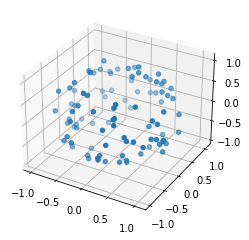

In [5]:
dimension = 3

point_cloud = generate_point_cloud_from_sphere(num_points=100, radius=1, dim=dimension, error=.1)
fig = draw_point_cloud(point_cloud)
plt.show()

Alternativily you can can load a point cloud from an [OFF file](https://gudhi.inria.fr/python/latest/fileformats.html) in the following way.

In [5]:
point_cloud = gudhi.read_points_from_off_file(off_file="path_to_off_file.off")

## Vietoris-Rips Complex (RipsComplex)
Given a point cloud $S$, and for all $\varepsilon > 0$, the Vietoris-Rips Complex is defined as follows

$VR_{\varepsilon}=\left\{\sigma\subseteq S\;|\; d(x,y)\leq 2\varepsilon\right\}$

We can think about adding $\varepsilon$-balls around each point in the point cloud with radius $\varepsilon$, and when two $\varepsilon$-balls intersect we add an edge. Using this method we can create the VR Filtered complex by incrementally increasing $\varepsilon$. See [this](https://www.geogebra.org/m/ed7zxccq) for a helpful Vietoris-Rips Complex Simulator. Or see page 15 of [A roadmap for the computation of persistent homology](https://epjdatascience.springeropen.com/articles/10.1140/epjds/s13688-017-0109-5) for a more formal definition along with algorithmic approaches to create the VR complex

Gudhi allows us to create a filtered Vietoris Rips complex through the use of the class `RipsComplex`. See [here](https://gudhi.inria.fr/python/latest/rips_complex_user.html) and [here](https://gudhi.inria.fr/python/latest/rips_complex_ref.html) for the documentation of this class. This class requires two parameters, first the array of points, our point_cloud, and `max_edge_length` which determines the maximum filtration value, or the largest value of $2\varepsilon$.

Once we have created the `RipsComplex` we need to create an instance of the class `SimplexTree` with is done with the function `create_simplex_tree` which requires the parameter `max_dimension`. This tells the simplex tree what the maximum size of simplex should be. It is recommended that you use the same dimension as the space in which the points we obtained from. A simplex tree is a data structure used to represent a filtered simplicial complex, as the VR complex. For the documentation of the simplex, tree see [here](https://gudhi.inria.fr/python/latest/simplex_tree_ref.html).



In [6]:
start_time = time.time()

rips_complex = gudhi.RipsComplex(points=point_cloud, max_edge_length=3)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=dimension)

end_time = time.time()
print(f"Complex and Simplex Tree computed in {end_time - start_time} seconds")
print('Normal: Rips complex is of dimension ', simplex_tree.dimension(), ' - ', simplex_tree.num_simplices(), ' simplices - ', simplex_tree.num_vertices(), ' vertices.')


print(f"Rips Complex: Simplex Tree created with dimension {simplex_tree.dimension()} from {simplex_tree.num_vertices()} points")

Complex and Simplex Tree computed in 0.5481562614440918 seconds
Normal: Rips complex is of dimension  3  -  4087975  simplices -  100  vertices.
Rips Complex: Simplex Tree created with dimension 3 from 100 points


Once we have created the simplex tree we can see the properties of the filtered simplicial complex. 

One useful feature is the function `get_filtration` which allows us to see a complete list of the simplexes and at what filtration they are added into a complex. 
For example if we have (\[54, 166, 195\], 0.05485216099610638) we that the $2$-simplex is added at filtration value 0.05485216099610638, or in our case with the rips complex, when $\varepsilon=0.027$ or half the filtration value.

The code below prints out the total number of simplexes at the final filtration value or `max_edge_length` and the first 400 simplexes added based on filtration values.

Note: this functions tends to be very slow especially with higher dimensions. Skip this step if you dont need to know the filtrations values

In [5]:
filtrations = list(simplex_tree.get_filtration())

print(f"There are {simplex_tree.num_simplices()} total simplexes") 
print("First 120 simplexes added, by Filtration:\n")
for simplex in filtrations[:min(400,len(filtrations))]:
    print(tuple(simplex))

There are 4087975 total simplexes
First 120 simplexes added, by Filtration:

([0], 0.0)
([1], 0.0)
([2], 0.0)
([3], 0.0)
([4], 0.0)
([5], 0.0)
([6], 0.0)
([7], 0.0)
([8], 0.0)
([9], 0.0)
([10], 0.0)
([11], 0.0)
([12], 0.0)
([13], 0.0)
([14], 0.0)
([15], 0.0)
([16], 0.0)
([17], 0.0)
([18], 0.0)
([19], 0.0)
([20], 0.0)
([21], 0.0)
([22], 0.0)
([23], 0.0)
([24], 0.0)
([25], 0.0)
([26], 0.0)
([27], 0.0)
([28], 0.0)
([29], 0.0)
([30], 0.0)
([31], 0.0)
([32], 0.0)
([33], 0.0)
([34], 0.0)
([35], 0.0)
([36], 0.0)
([37], 0.0)
([38], 0.0)
([39], 0.0)
([40], 0.0)
([41], 0.0)
([42], 0.0)
([43], 0.0)
([44], 0.0)
([45], 0.0)
([46], 0.0)
([47], 0.0)
([48], 0.0)
([49], 0.0)
([50], 0.0)
([51], 0.0)
([52], 0.0)
([53], 0.0)
([54], 0.0)
([55], 0.0)
([56], 0.0)
([57], 0.0)
([58], 0.0)
([59], 0.0)
([60], 0.0)
([61], 0.0)
([62], 0.0)
([63], 0.0)
([64], 0.0)
([65], 0.0)
([66], 0.0)
([67], 0.0)
([68], 0.0)
([69], 0.0)
([70], 0.0)
([71], 0.0)
([72], 0.0)
([73], 0.0)
([74], 0.0)
([75], 0.0)
([76], 0.0)
([77], 0.

## Interpreting the Data, Barcodes and Persistance diagrams
In this section, we will explore the different tools Gudhi has for interpreting the simplicial complexes
### Barcodes
First, we will look at bar codes which are a representation of the homology. For an introduction to homoloy and how it's applied to detected features in a complex see section 3 of [A roadmap for the computation of persistent homology](https://epjdatascience.springeropen.com/articles/10.1140/epjds/s13688-017-0109-5). The documentation for the plotting function in Gudhi can be found [here](https://gudhi.inria.fr/python/latest/persistence_graphical_tools_ref.html).
Barcodes are used to visualize the persistent homology of the filtered complex. Each bar represents the lifespan of the feature in the filtered complex.
The longer a bar is, or the longer its life span is the more likely it is a feature in the underlying topological space and the more we care about it.

Barcodes computed in 3.2517549991607666 seconds
Barcodes:


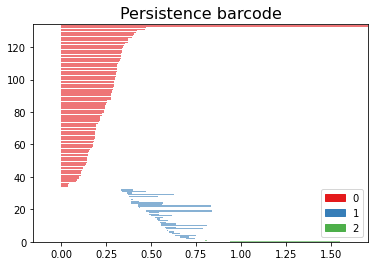

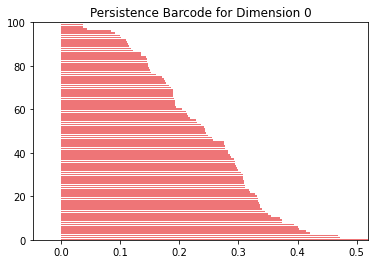

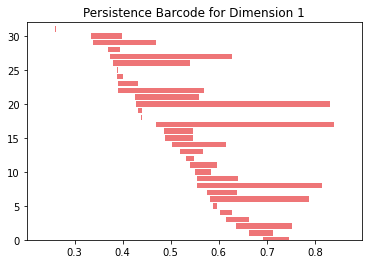

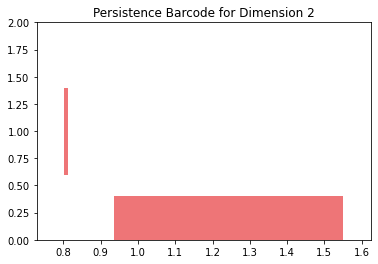

In [6]:
# Note: this is a "standalone" function meaning you can run it once your simplex tree has been created

start_time = time.time()
barcodes = simplex_tree.persistence()
end_time = time.time()
print(f"Barcodes computed in {end_time - start_time} seconds")

print(f"Barcodes:")
gudhi.plot_persistence_barcode(barcodes, legend=True)
plt.show()

for i in range(simplex_tree.dimension()):
    # Note: note this is not a standalone function. This function only works after either simplex_tree.persistence() or simplex_tree.compute_persistence() has been run
    barcodes_i = simplex_tree.persistence_intervals_in_dimension(i)
    if len(barcodes_i) == 0:
         break
    ax = gudhi.plot_persistence_barcode(barcodes_i)
    ax.set_title(f"Persistence Barcode for Dimension {i}")
    plt.show()

Based on the above plots and specifically the barcode for dimension 1, we know that $\text{dim}(H_1)=1$ for a large majority of the filtration. This indicates that there is very likely a large hole in the point cloud, which is exactly what we expect to see as the point cloud was a circle. 
### Persistence Diagrams
Similar to the Barcode plots we can create persistence diagrams, which represent the same data but in a different way. Each point represents a feature, and in general, the further a point is from the identity line the longer the life span is, and therefore the more likely it is a feature in the underlying topology.

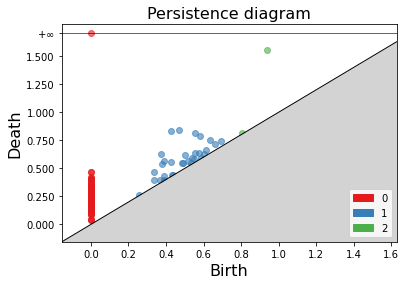

In [7]:
gudhi.plot_persistence_diagram(barcodes, legend=True)
plt.show()

## Other Complexes
Gudhi supports many different complexes in which you can use to compute persistent homologies including the [Cubical Complexes](https://gudhi.inria.fr/python/latest/cubical_complex_user.html) which are used primarily in the context of images. And [Alpha Complexes](https://gudhi.inria.fr/python/latest/alpha_complex_user.html), [Witness Complexes](https://gudhi.inria.fr/python/latest/witness_complex_user.html), [Cover Complexes](https://gudhi.inria.fr/python/latest/nerve_gic_complex_user.html) (Nerves and graph induced complexes), and [Tangential Complexes](https://gudhi.inria.fr/python/latest/tangential_complex_user.html). Additionally, Gudhi also supports the computation of [Persistent Cohomology](https://gudhi.inria.fr/python/latest/persistent_cohomology_user.html)

## Sparse Vietros-Rips Complex
Gudhi supports different variations of the Rips complex, one option the sparse Rips complex, which is an approximation of the VR complex. In the worse case, the VR complex will have exponentially many, $2^{O(n)}$, simplixes for a point cloud with $n$ points. The sparse VR complex can reduce the number of simplixes to be linear $O(n)$ with respect to the number of points in the point cloud. However, it is important to note that this approximation is not guaranteed to preserve the Homology.

The sparse approximation is what is called a $(1+\epsilon)$-approximation, where the value for $\epsilon$ can vary changing how good of an approximation it is. When $\epsilon=0$ the approximation is no different than the actual persistent Homology and as $\epsilon$ increases the approximation gets worse.

In the example $\epsilon=.5$ which is set with the sparse parameter.
Even with $\epsilon=.5$ we see a rather large speed up.


Complex and Simplex Tree (Sparse) computed in 0.06499314308166504 seconds
Sparse Rips complex is of dimension  3  -  159081  simplices -  100  vertices.
Barcodes (Sparse) computed in 0.14899253845214844 seconds
Barcodes:


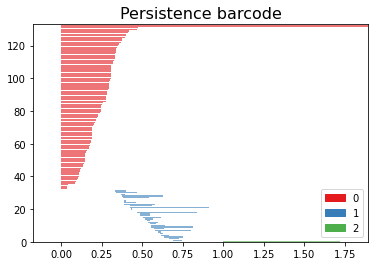

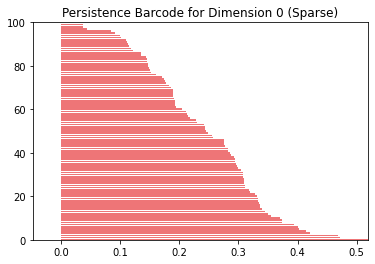

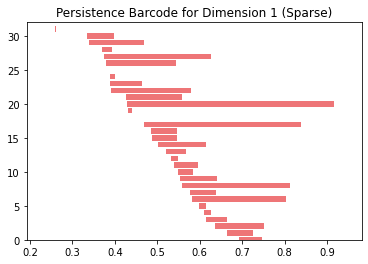

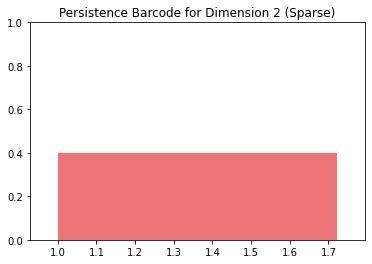

In [8]:
# We will recreate objects for the rips complex and simplex tree with the parameter sparse set to .5 meaning this will be a 1.5-approx
start_time = time.time()

rips_complex_sparse = gudhi.RipsComplex(points=point_cloud, max_edge_length=3, sparse=.5)
simplex_tree_sparse = rips_complex_sparse.create_simplex_tree(max_dimension=dimension)

end_time = time.time()
print(f"Complex and Simplex Tree (Sparse) computed in {end_time - start_time} seconds")
print('Sparse Rips complex is of dimension ', simplex_tree_sparse.dimension(), ' - ', simplex_tree_sparse.num_simplices(), ' simplices - ', simplex_tree_sparse.num_vertices(), ' vertices.')

# Create barcodes
start_time = time.time()
barcodes_sparse = simplex_tree_sparse.persistence()
end_time = time.time()
print(f"Barcodes (Sparse) computed in {end_time - start_time} seconds")

# From the barcodes from the sparse Rips complex we can create the barcode graphs
print(f"Barcodes:")
gudhi.plot_persistence_barcode(barcodes_sparse, legend=True)
plt.show()

for i in range(simplex_tree_sparse.dimension()):
    barcodes_i_sparse = simplex_tree_sparse.persistence_intervals_in_dimension(i)
    if len(barcodes_i_sparse) == 0:
         break
    ax = gudhi.plot_persistence_barcode(barcodes_i_sparse)
    ax.set_title(f"Persistence Barcode for Dimension {i} (Sparse)")
    plt.show()

Increasing the value of $\epsilon$ can give us an even faster approximation algorithm. However increasing the value too high can result in the features not being detected. For example when $\epsilon=3$ we were unable to find the 2-hole or void

Complex and Simplex Tree (Sparse) computed in 0.001026153564453125 seconds
Sparse Rips complex is of dimension  3  -  322  simplices -  100  vertices.
Barcodes (Sparse) computed in 0.0010001659393310547 seconds
Barcodes:


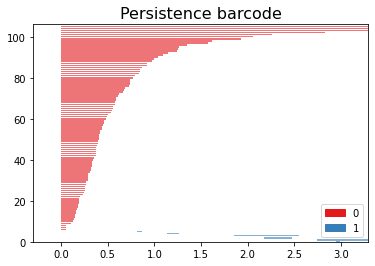

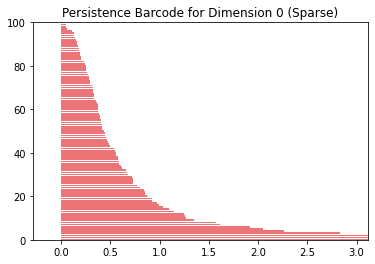

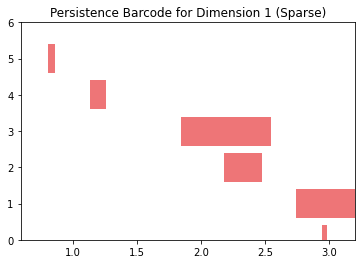

In [10]:
# We will recreate objects for the rips complex and simplex tree with the parameter sparse set to 3 meaning this will be a 4-approx
start_time = time.time()

rips_complex_sparse = gudhi.RipsComplex(points=point_cloud, max_edge_length=3, sparse=3)
simplex_tree_sparse = rips_complex_sparse.create_simplex_tree(max_dimension=dimension)

end_time = time.time()
print(f"Complex and Simplex Tree (Sparse) computed in {end_time - start_time} seconds")
print('Sparse Rips complex is of dimension ', simplex_tree_sparse.dimension(), ' - ', simplex_tree_sparse.num_simplices(), ' simplices - ', simplex_tree_sparse.num_vertices(), ' vertices.')

# Create barcodes
start_time = time.time()
barcodes_sparse = simplex_tree_sparse.persistence()
end_time = time.time()
print(f"Barcodes (Sparse) computed in {end_time - start_time} seconds")

# From the barcodes from the sparse Rips complex we can create the barcode graphs
print(f"Barcodes:")
gudhi.plot_persistence_barcode(barcodes_sparse, legend=True)
plt.show()

for i in range(simplex_tree_sparse.dimension()):
    barcodes_i_sparse = simplex_tree_sparse.persistence_intervals_in_dimension(i)
    if len(barcodes_i_sparse) == 0:
         break
    ax = gudhi.plot_persistence_barcode(barcodes_i_sparse)
    ax.set_title(f"Persistence Barcode for Dimension {i} (Sparse)")
    plt.show()